This is the beginning of the data cleaning and some very short exploratory analysis. 

In the end of the notebook is a dataframe that is similar to what we will have as an imput for the decision tree. 
So far only for the pickup of the bikes, but we will do the same for the return of the bikes. 

It is really just a rough start of the data preprocessing, only to make you more familiar with the data. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import os 
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import math
import numpy as np
import copy
import holidays
import json 
cwd = os.getcwd()
us_holidays = holidays.UnitedStates()

In [3]:
from os import listdir
from os.path import isfile, join

path = cwd+'/data/tripdata'
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

In [4]:
data = pd.read_csv(path+'/'+files[0])
for file in files[1:]:
    data_month = pd.read_csv(path+'/'+file)
    print(data.shape, data_month.shape)
    data = data.append(data_month, ignore_index = True)
    
data['starttime'] = pd.to_datetime(data['Start date'], format='%Y-%m-%d %H:%M:%S')

(374115, 9) (392338, 9)
(766453, 9) (404761, 9)


In [5]:
data.columns

Index(['Duration', 'Start date', 'End date', 'Start station number',
       'Start station', 'End station number', 'End station', 'Bike number',
       'Member type', 'starttime'],
      dtype='object')

# geo data

In [6]:
stations = pd.read_csv(cwd+'/data/Capital_Bike_Share_Locations.csv')

In [7]:
# stations.head()

In [8]:
stations['CAPACITY'] = stations.NUMBER_OF_BIKES+stations.NUMBER_OF_EMPTY_DOCKS
stations = stations[['TERMINAL_NUMBER', 'LATITUDE', 'LONGITUDE', 'CAPACITY']]
stations.columns = ['id', 'latitude', 'longitude', 'capacity']

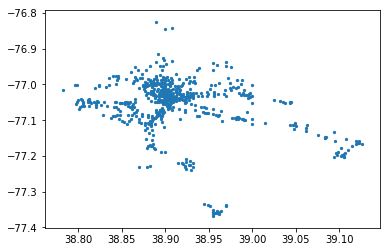

In [9]:
plt.scatter(stations.latitude, stations.longitude, marker='.', s=20)

Because the rented bikes per hour were pretty small at one station, I had the idea of combining stations that are close to each other. Because as a user you are usually not fixed on a specific station, you would look on the map in the application and then go to any close station that has bikes. 

In the next step I manually combined the stations that are close to each other imagine a grid that lays over the map and all the stations in one cell are combined to one. 
If we bundle stations, we should think about a smarter way.

In [10]:
def sort_in_clusters(data, level, grid_size, suffix=None):
    grid_size = grid_size+1
    threshold_lats = np.linspace(data.latitude.min(), data.latitude.max(), grid_size)
    threshold_lons = np.linspace(data.longitude.min(), data.longitude.max(), grid_size)

    layers = data[['id', 'latitude', 'longitude']]
    
    layers['lat'] = 0
    for i in range(1,len(threshold_lats)):
        layers['lat'][layers.latitude >= threshold_lats[i]] = i*100
    
    layers['lon'] = 0
    for i in range(1,len(threshold_lons)):
        layers['lon'][layers.longitude >= threshold_lons[i]] = i
        
    if level == 'clustering':
        layers['help_id'] = layers.lat+layers.lon
        size = layers.help_id.value_counts()
        id_dict = size.reset_index().reset_index().rename(columns={'level_0':'cluster_id', 'index':'help_id', 'help_id':'count'})
        stations_rough = layers.merge(id_dict, how='left', left_on='help_id', right_on='help_id')[['id', 'cluster_id', 'latitude', 'longitude']]
        return stations_rough
    else:
        if level == 1:
            layers['L1'] = layers.apply(lambda x: str(int(x.lat+x.lon)), axis=1)
        else:
            layers['L'+str(level)] = layers.apply(lambda x: str(suffix) + '_' + str(int(x.lat+x.lon)), axis=1)
        return layers[['id', 'L'+str(level)]]

In [11]:
stations_rough = sort_in_clusters(stations, 'clustering', 32)

# Kfir's 'Location-Clusters' 
with levels where we devide intereseting areas again in the next level

In [12]:
# layers - sub-layers
# level 1, devide in 4 parts
layers = sort_in_clusters(stations, level=1, grid_size=4)
stations = stations.merge(layers, how='left', left_on='id', right_on='id').fillna('0')

In [13]:
# level 2, take busy clusters from level 1 and divide in 3 parts
layers_combined = pd.DataFrame(columns=['id', 'L2'])
for L1_id in ['102', '2']:
    data_subcluster = stations[stations.L1 == L1_id]
    layers = sort_in_clusters(data_subcluster, level=2, grid_size=4, suffix=L1_id)
    layers_combined = pd.concat([layers_combined, layers], join='inner', ignore_index=True)

In [14]:
layers_combined['id'] = layers_combined.id.apply(lambda x: int(x))  # transform into in, otherwise merge doesnt work
stations = stations.merge(layers_combined, how='left', left_on='id', right_on='id').fillna('0')

In [15]:
# expand stations_rough with L1 and L2 information
stations_rough = stations_rough.merge(stations[['id', 'L1', 'L2']], how='left', left_on='id', right_on='id')
cluster_size = stations_rough.groupby(by=['cluster_id', 'L1', 'L2']).count().reset_index().rename(columns={'id': 'cluster_size'})[
    ['cluster_id', 'cluster_size', 'L1', 'L2']]

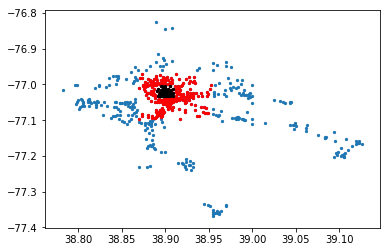

In [16]:
plt.scatter(stations.latitude, stations.longitude, marker='.', s=20)

p = stations_rough
prob2 = stations[stations.id.apply(lambda x: x in set(p[p.L2 == '102_102'].id))]
prob = stations[stations.id.apply(lambda x: x in set(p[p.L1 == '102'].id))]
plt.scatter(prob.latitude, prob.longitude, marker='.', c='r', s=20)
plt.scatter(prob2.latitude, prob2.longitude, marker='.', c='k', s=20)

In [17]:
stations_rough.head(10)

,id,cluster_id,latitude,longitude,L1,L2
0,31324,0,38.911268,-77.041829,102,102_201
1,32231,100,38.882800,-77.228300,101,0
2,32408,76,38.959361,-76.946361,203,0
3,32409,66,38.840107,-76.975300,2,2_203
4,32410,76,38.954600,-76.959500,203,0
5,32411,104,38.975505,-76.952199,203,0
6,32412,103,38.974205,-76.995227,202,0
7,32413,67,38.939271,-76.955047,103,0
8,32414,162,38.972500,-76.980700,202,0
9,32415,107,38.796800,-77.002600,2,2_2


the hardcoded fix of some data impurity. No idea why, but somehow some of the cluster_ids appeared in different clusters in L2 even though this should not happen. Probably some problem with rounding the latitude and longitude numbers. So I assigned the whole cluster_id to the L2-cluster, that contains the most stations. 

In [18]:
def remerge_clusters(data, cluster_id):
    subset = data[data.cluster_id == cluster_id]
    if subset.shape[0] > 1:
        total_size = sum(subset.cluster_size)
        L1 = subset['L1'][subset.cluster_size == subset.cluster_size.max()].iloc[0]
        L2 = subset.L2[subset.cluster_size == subset.cluster_size.max()].iloc[0]
        new_row = pd.DataFrame(data=[[cluster_id, total_size, L1, L2]], columns=list(subset.columns))
        return(new_row)
    else:
        return(subset)
    
cluster_info = pd.DataFrame(columns=cluster_size.columns)
for i in range(0, cluster_size.cluster_id.max()):
    new_row = remerge_clusters(cluster_size, i)
    cluster_info = pd.concat([cluster_info, new_row], ignore_index=True)

In [19]:
cluster_info = pd.DataFrame(columns=cluster_size.columns)
for i in range(0, cluster_size.cluster_id.max()):
    new_row = remerge_clusters(cluster_size, i)
    cluster_info = pd.concat([cluster_info, new_row], ignore_index=True)

cluster_info['cluster_id'] = cluster_info.cluster_id.apply(lambda x: int(x))

In [20]:
cluster_size = cluster_info

In [21]:
cluster_size.head()

,cluster_id,cluster_size,L1,L2
0,0,19,102,102_101
1,1,16,102,102_101
2,2,14,102,102_102
3,3,14,102,102_102
4,4,13,102,102_201


In [22]:
stations.head()

,id,latitude,longitude,capacity,L1,L2
0,31324,38.911268,-77.041829,19,102,102_201
1,32231,38.882800,-77.228300,16,101,0
2,32408,38.959361,-76.946361,8,203,0
3,32409,38.840107,-76.975300,15,2,2_203
4,32410,38.954600,-76.959500,15,203,0


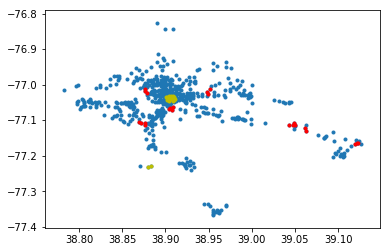

In [23]:
plt.scatter(stations_rough.latitude, stations_rough.longitude, marker='.')
s01 = stations_rough[stations_rough.cluster_id.apply(lambda x: x in set([100, 0]))]
plt.scatter(s01.latitude, s01.longitude, marker='.', c='y')

clust = stations_rough[stations_rough.cluster_id.apply(lambda x: x in set([40, 54, 41, 55, 83, 42, 58]))]
plt.scatter(clust.latitude, clust.longitude, marker='.', c='r')

## Weather data here:

In [24]:
with open(cwd+'/data/weatherdata.json') as json_file:
    weather = json.load(json_file)
weather_df = pd.DataFrame(weather['observations'])
weather_df['datetime'] = pd.to_datetime(weather_df['time_gmt'], format='%Y-%m-%d %H:%M:%S')

In [25]:
phrases = weather_df.phrase.value_counts()  # TODO: yyyey... data cleaning!
phrases = phrases.reset_index()

In [26]:
phrases['wind'] = phrases['index'].apply(lambda x: int('Windy' in x))

In [27]:
winter = ['Wintry', 'Snow', 'Freezing', 'Sleet']
thunder = ['T-', 'Thunder', 'Squalls']
extreme = ['Heavy', 'T-Storm', 'Thunder', 'Squalls']

phrases['wintry'] = phrases['index'].apply(lambda x: int(any([term in x for term in winter])))
phrases['thunderstorm'] = phrases['index'].apply(lambda x: int(any([term in x for term in thunder])))
phrases['extreme_weather'] = phrases['index'].apply(lambda x: int(any([term in x for term in extreme])))

In [28]:
light_rain = ['Light Rain', 'Light Drizzle', 'Light Freezing Rain'] # give 1
heavy_rain = ['Rain', 'Heavy Rain'] # give 2, do this first because otherwise would overwrite 'Light Rain'
foggy = ['Fog', 'Mist', 'Haze']
clear_sky = ['Fair', 'Partly Cloudy'] # give 1

phrases['foggy'] = phrases['index'].apply(lambda x: int(any([term in x for term in foggy])))

phrases['rain'] = 0
phrases['rain'][phrases['index'].apply(lambda x: any([term in x for term in heavy_rain]))] = 2
phrases['rain'][phrases['index'].apply(lambda x: any([term in x for term in light_rain]))] = 1

phrases['clear_sky'] = phrases['index'].apply(lambda x: int(any([term in x for term in clear_sky])))

In [29]:
phrases = phrases.drop(columns='phrase')
phrases.rename(columns={'index': 'phrase'}, inplace=True)

In [30]:
weatherdata = weather_df
weather_phrases = phrases

# tripdata to pickups per station 
and per time window of 90 minutes

In [31]:
# within next 90 minutes will have x pickups at station
time = datetime(year=2018, month=5, day=25, hour=0, minute=0)
delta = timedelta(minutes=90)

data = data[['starttime', 'Start station number']]
data_year = stations_rough[['id', 'cluster_id']].merge(data, how='right', left_on='id', right_on='Start station number')[
        ['starttime', 'cluster_id']]

pickup_list = list()
for i in range(0,16):
    print(time, time+delta)
    pickups = data_year[(data_year.starttime >= time) &
                 (data_year.starttime < time + delta)].groupby(['cluster_id']).count()
#                      (data_s.starttime < time+delta)].groupby(['id', 'latitude', 'longitude', 'Member type']).count()
   
    # multi-index to single index and rename columns
    pickups = pickups.reset_index()
    pickups.rename(columns={'starttime': 'pickups'}, inplace=True)
    pickups = cluster_size.merge(pickups, how='left', left_on='cluster_id', right_on='cluster_id').fillna(0)
    
    pickups['holiday'] = int(time in us_holidays)
    pickups['weekday'] = time.weekday()
    pickups['datetime'] = time
    pickups['time'] = time.time()
    pickups['month'] = time.month

    # weather data
    try:
        current_weather = weatherdata[(weatherdata.datetime >= time - timedelta(minutes=30)) &
                                     (weatherdata.datetime < time + timedelta(minutes=29))].iloc[0]
    except IndexError:
        print('use last available weather information')
        pass

    pickups['phrase'] = current_weather['phrase']
    pickups['temperature'] = current_weather['temp']
    pickups['humidity'] = current_weather['humidity']
    pickups = pickups.merge(weather_phrases, how='left')
    pickups = pickups.drop(columns='phrase')

    pickup_list.append(pickups)
    time += delta


2018-05-25 00:00:00 2018-05-25 01:30:00
2018-05-25 01:30:00 2018-05-25 03:00:00
2018-05-25 03:00:00 2018-05-25 04:30:00
2018-05-25 04:30:00 2018-05-25 06:00:00
2018-05-25 06:00:00 2018-05-25 07:30:00
2018-05-25 07:30:00 2018-05-25 09:00:00
2018-05-25 09:00:00 2018-05-25 10:30:00
2018-05-25 10:30:00 2018-05-25 12:00:00
2018-05-25 12:00:00 2018-05-25 13:30:00
2018-05-25 13:30:00 2018-05-25 15:00:00
2018-05-25 15:00:00 2018-05-25 16:30:00
2018-05-25 16:30:00 2018-05-25 18:00:00
2018-05-25 18:00:00 2018-05-25 19:30:00
2018-05-25 19:30:00 2018-05-25 21:00:00
2018-05-25 21:00:00 2018-05-25 22:30:00
2018-05-25 22:30:00 2018-05-26 00:00:00


In [32]:
# create long dataframe from short sub-windows
pickups = pickup_list[0]

for i in range(1, len(pickup_list)):
    pickups_new = pickup_list[i]
    pickups = pickups.append(pickups_new, ignore_index=True)
    print(pickups_new.shape, pickups.shape)

(170, 19) (340, 19)
(170, 19) (510, 19)
(170, 19) (680, 19)
(170, 19) (850, 19)
(170, 19) (1020, 19)
(170, 19) (1190, 19)
(170, 19) (1360, 19)
(170, 19) (1530, 19)
(170, 19) (1700, 19)
(170, 19) (1870, 19)
(170, 19) (2040, 19)
(170, 19) (2210, 19)
(170, 19) (2380, 19)
(170, 19) (2550, 19)
(170, 19) (2720, 19)


This dataframe above is the most minimal version of what we will have as the input of the decision trees. 

- station_id: identifier (here I used the grid-ids, the "combined stations")
- lat/lon: location of the station, here one-to-one mapping

other variables that will be usefull for the decision tree:
- timeframe: We should think about how to represent the timeframe better, here I just used the end-time. 
- weekday/weekend: either 0-1 (two categories) or 0-6 (each day)
- holiday: 0-1
- season: 0-3 (4 seasons), or 0-11 (12 months)?
- weather: sunny, rainy, windy, snowy, cold ... I really think we should put in some effort to get data. It should not take too long once we've found a nice dataset
- inner-/outer city: maybe we don't need it because it is already somehow captured in the location (lat/lon). Will have high correlation with this one
- how many other stations in cluster: No idea if it's important, but I guess it has some relevance.
- ... please complete
- type of customer (member or casual), it really makes a difference!

target variable:
- pickups: how many bikes got picked up at the station. Integers or integer-ranges?

In [33]:
# logarithmic value to see the distribution better in the color scheme
pickups['log_pickups'] = np.log(pickups.pickups) 

In [34]:
# merge back, from cluster to all stations in cluster
pickups = pickups.merge(stations_rough[['cluster_id', 'id', 'latitude', 'longitude']], how='left', left_on='cluster_id', right_on='cluster_id')

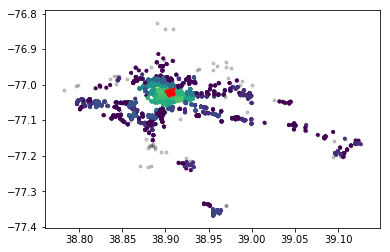

In [35]:
plt.scatter(stations_rough.latitude, stations_rough.longitude, marker='.', c='k', alpha=0.2)
plt.scatter(pickups.latitude, pickups.longitude, marker='.', c=pickups.log_pickups, cmap='viridis')
prob = stations[stations.id.apply(lambda x: x in set(p[p.cluster_id == 7].id))]
plt.scatter(prob.latitude, prob.longitude, marker='.', c='r')

# plt.colorbar()

In [36]:
def log_rel_pickups(x, minimum):
    if x == 0:
        return minimum*1.00000001
    else:
        return np.log(x)

In [37]:
grid_size = 4+1
threshold_lats_1 = np.linspace(stations.latitude.min(), stations.latitude.max(), grid_size)
threshold_lons_1 = np.linspace(stations.longitude.min(), stations.longitude.max(), grid_size)

In [38]:
morning = pickups[pickups.time == datetime(year=2018, month=5, day=25, hour=7, minute=30).time()].reset_index()
morning['rel_pickups'] =  morning.pickups/morning.cluster_size
min_rel = morning.rel_pickups.min()
morning['log_rel_pickups'] = morning.rel_pickups.apply(lambda x: log_rel_pickups(x, min_rel))

evening = pickups[pickups.time == datetime(year=2018, month=5, day=25, hour=16, minute=30).time()].reset_index()
evening['rel_pickups'] =  evening.pickups/evening.cluster_size
min_rel = evening.rel_pickups.min()
evening['log_rel_pickups'] = evening.rel_pickups.apply(lambda x: log_rel_pickups(x, min_rel))

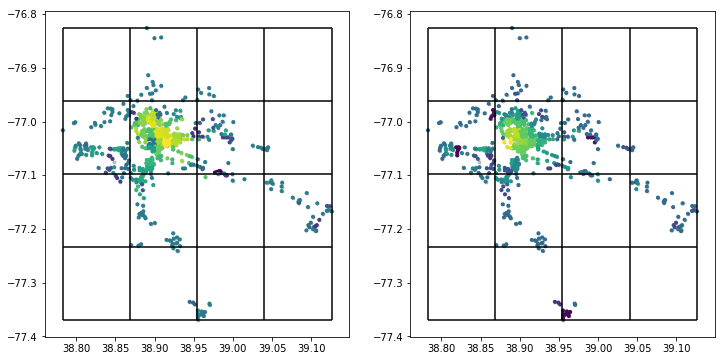

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.scatter(stations.latitude, stations.longitude, marker='.', c='k', alpha=0.2)
ax.scatter(morning.latitude, morning.longitude,  marker='.', c=morning.log_rel_pickups)
ax.vlines(x=threshold_lats_1, ymin=stations.longitude.min(), ymax=stations.longitude.max())
ax.hlines(y=threshold_lons_1, xmin=stations.latitude.min(), xmax=stations.latitude.max())

ax = axs[1]
ax.scatter(stations.latitude, stations.longitude, marker='.', c='k', alpha=0.2)
ax.scatter(evening.latitude, evening.longitude,  marker='.', c=evening.log_rel_pickups, cmap='viridis')
ax.vlines(x=threshold_lats_1, ymin=stations.longitude.min(), ymax=stations.longitude.max())
ax.hlines(y=threshold_lons_1, xmin=stations.latitude.min(), xmax=stations.latitude.max())

# Calculate demand

Demand is equal to returns that happened until 30 minutes ago, minus pickups.

This would result in a range of -260 to +260. The extreme values are in the center of the city at clusters 0 and 1, the peak times are 9:00, where we have much more returns than pickups (+260), and 16:30 where we have much more pickups than returns. But also, the clusters in the center contain more stations than the ones outside (they are more dense), which suggests to calculate first the demand (demand = returns - pickups, negative numbers means we haven't had enough bikes, -x --> x bikes are missing, positive numbers: we had more returns than pickups, have x bikes over). 

The next step is to calculate the relative demand, which is demand_per_cluster/cluster_size. To get the relative demand per station. Otherwise of course big clusters will have more extreme values than small clusters. This results in decimal numbers, e.g. a cluster of size 3 with demand 10 has relative demand 3.33333.

Since we want to predict the relative demand, decimal numbers are very impractical. Using the next bigger integer leads to a good approximation. (math.ceil(3.3333) --> 4) When this is calculated now back to the whole cluster, we would get a prediction of 4*3=12 pickups, which is still relatively close. 


To think about it for extreme values: 

Assume we had 4 pickups in a cluster of 5 stations, or 1 pickup in a cluster of 5 stations, then we get a decimal number x between 0 and 1. math.ceil(x)=1 in any case. Multiplied by the number_of_stations_in_cluster we get one pickup per station. It is an over-estimation but makes sense in the real world application. The service provider prefers to over-supply bikes to ensure a smooth service. 

With this method we get the target variable (demand prediction) 'ceil', which ranges from about -22 to +31. 
(Haven't seen all the numbers yet, this was the result for 2018.)

In [40]:
pickups = pd.read_pickle(cwd+'/data/pickups_2018.pkl')
returns = pd.read_pickle(cwd+'/data/returns_2018.pkl')

In [41]:
pickups['rel_pickups'] = pickups.pickups/pickups.cluster_size
returns['rel_returns'] = returns.returns/returns.cluster_size

results = copy.deepcopy(returns)
results['demand'] = returns.returns - pickups.pickups
results['rel_demand'] = results.demand/results.cluster_size

In [42]:
results['ceil'] = results['rel_demand'].apply(lambda x: math.ceil(x))

In [43]:
results = results[['cluster_id', 'L1', 'L2', 
                   'weekday', 'holiday', 'time', 
                   'month', 'clear_sky', 'extreme_weather', 
                   'foggy', 'humidity', 'thunderstorm', 
                   'rain', 'temperature', 'wind', 
                   'wintry', 'ceil']]

In [44]:
hist = results.groupby(by='ceil').count().reset_index()

(0, 4000)

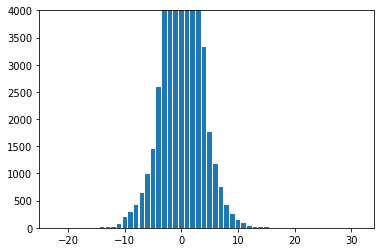

In [45]:
plt.bar(x = hist['ceil'], height=hist['cluster_id'])
plt.ylim(0,4000)

# Drop zero-rows in pickup and returns

In [46]:
year = 2017
pickups = pd.read_pickle(cwd+'/data/pickups_' + str(year) + '.pkl')
returns = pd.read_pickle(cwd+'/data/returns_' + str(year) + '.pkl')

returns_wo_zero = returns[returns.returns != 0]
pickups_wo_zero = pickups[pickups.pickups != 0]

returns_wo_zero.to_csv(cwd+'/data/returns_wo_zero_' + str(year) + '.csv')
pickups_wo_zero.to_csv(cwd+'/data/pickups_wo_zero_' + str(year) + '.csv')

# Drop variables that we are not interested in 

In [47]:
results = results[['cluster_id', 'L1', 'L2', 
                   'weekday', 'holiday', 'time', 
                   'month', 'clear_sky', 'extreme_weather', 
                   'foggy', 'humidity', 'thunderstorm', 
                   'rain', 'temperature', 'wind', 
                   'wintry', 'ceil']]

# Fix New Years issue

In [78]:
for year in [2016, 2017, 2018, 2019]:
    print(year)
    pickups = pd.read_pickle(cwd+'/data/pickups_' + str(year) + '.pkl')
    pickups_jan = pd.read_pickle(cwd+'/data/pickups_jan_' + str(year) + '.pkl')

    returns = pd.read_pickle(cwd+'/data/returns_' + str(year) + '.pkl')
    returns_jan = pd.read_pickle(cwd+'/data/returns_jan_' + str(year) + '.pkl')

    start = datetime(year=year, month=1, day=1, hour=0, minute=0)
    end   = datetime(year=year, month=2, day=1, hour=0, minute=0) 
    pickups_rest = pickups[~((pickups.datetime >= start) & (pickups.datetime < end))]
    returns_rest = returns[~((returns.datetime >= start) & (returns.datetime < end))]
    

    pickups_new = pd.concat([pickups_jan, pickups_rest], ignore_index=True)
    print(pickups_new.shape, pickups.shape)
    pickups_new.to_csv(cwd+'/data/pickups_' + str(year) + '.csv')
    pickups_new.to_pickle(cwd+'/data/pickups_' + str(year) + '.pkl')

    returns_new = pd.concat([returns_jan, returns_rest], ignore_index=True)
    print(returns_new.shape, returns.shape)
    returns_new.to_csv(cwd+'/data/returns_' + str(year) + '.csv')
    returns_new.to_pickle(cwd+'/data/returns_' + str(year) + '.pkl')

2016
(989664, 20) (989664, 20)
(989664, 19) (989664, 19)
2017
(986960, 20) (986960, 20)
(986960, 19) (986960, 19)
2018
(986960, 20) (986960, 20)
(986960, 19) (986960, 19)
2019
(489424, 20) (489424, 20)
(489424, 19) (489424, 19)


# Combine yearly results to whole results:

In [91]:
path = cwd+'/data/combine'
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()
files

data = pd.read_pickle(path+'/'+files[0])
for file in files[1:]:
    print('load file: ', file)
    data_new = pd.read_pickle(path+'/'+file)
    print(data.shape, data_new.shape)
    data = pd.concat([data, data_new], ignore_index=True)

print('save file')
data.to_csv(cwd + '/data/combine/results_all.csv')
data.to_pickle(cwd + '/data/combine/results_all.pkl')

load file:  results_2012.pkl
(83824, 17) (83824, 17)
load file:  results_2013.pkl
(167648, 17) (83824, 17)
load file:  results_2014.pkl
(251472, 17) (83824, 17)
load file:  results_2015.pkl
(335296, 17) (83824, 17)
load file:  results_2016.pkl
(419120, 17) (989664, 17)
load file:  results_2017.pkl
(1408784, 17) (986960, 17)
load file:  results_2018.pkl
(2395744, 17) (986960, 17)
load file:  results_2019.pkl
(3382704, 17) (489424, 17)
save file


# What is next:

### Data:
- Data collection (trip data, stations, weather, holiday (bank-)...)
- more data cleaning and feature engineering, find more features
- split data for cross validation (leave out part for prediction of the trees and for training of the NNet/combination of trees)

### AI-Part:
#### Build trees
- code for decision tree with Entropy/Information Gain
- code for decision tree with random split
- random forest trees (where one variable is left out)
- other ways of building trees

#### Combine trees:
- uniformly
- with fancy Neural Nets
- something like AdaBoost

### Visualization
- demand on map
- time moving map?
- real-time prediction?

